In [1]:
import os, sys, time, logging
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Model

import ray, gym
from really import SampleManager
from really.utils import (
    dict_to_dict_of_datasets,
)

In [2]:
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel(logging.ERROR)

In [3]:
class QNetwork(Model):
    def __init__(self, 
                 input_shape=(4,), 
                 normalize_mean=None,
                 normalize_sd=None,
                 action_space=2):
        super(QNetwork, self).__init__()
        
        if normalize_mean is not None:
            assert normalize_sd is not None
            assert normalize_sd.shape == input_shape
            assert normalize_mean.shape == input_shape
        self.normalize_mean = normalize_mean
        self.normalize_sd = normalize_sd
        
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(16, 
                                  input_shape=input_shape, 
                                  activation='relu', 
                                  kernel_regularizer='l2'),
            tf.keras.layers.Dense(16, 
                                  activation='relu', 
                                  kernel_regularizer='l2'),
            tf.keras.layers.Dense(action_space, 
                                  activation='relu',
                                  use_bias=False)
        ])
        
    def call(self, x):
        if self.normalize_mean is not None:
            (x - self.normalize_mean) / self.normalize_sd
        x = self.mlp(x)
        return {"q_values": x}

<AxesSubplot:>

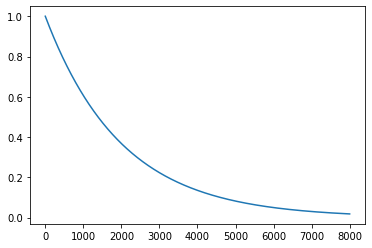

In [4]:
temperature_decay = 0.9995
_decay = lambda x,n: x * temperature_decay**n
ns = np.arange(8000)
temperature_init = 1.
seq = [_decay(temperature_init, n) for n in ns]
sns.lineplot(x=ns, y=seq)

In [5]:
ray.init(log_to_driver=False)

2021-03-02 15:45:12,708	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.178.30',
 'raylet_ip_address': '192.168.178.30',
 'redis_address': '192.168.178.30:6379',
 'object_store_address': '/tmp/ray/session_2021-03-02_15-45-12_220137_184459/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-03-02_15-45-12_220137_184459/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-03-02_15-45-12_220137_184459',
 'metrics_export_port': 64499,
 'node_id': 'ee333bd1836d1a973bee79a790b0bc147430dc4a9e454653cf5fb5dc'}

In [6]:
env_id = "CartPole-v1"
_env = gym.make(env_id)

In [7]:
model_kwargs = {
    "input_shape": _env.observation_space.shape,
    "action_space": _env.action_space.n,
    "normalize_mean": np.zeros(_env.observation_space.shape),
    "normalize_sd": np.ones(_env.observation_space.shape)
}
kwargs = {
    "model": QNetwork,
    "environment": env_id,
    "num_parallel": 5,
    "total_steps": 100,
    "num_episodes": 20,
    "action_sampling_type": "thompson",
    "temperature": temperature_init,
    "model_kwargs": model_kwargs
}
manager = SampleManager(**kwargs)

# test
data = manager.get_data(do_print=True, total_steps=1000)

# use moving averages to normalize state vector
moving_mean = np.mean(data['state'], axis=0)
moving_sd = np.std(data['state'], axis=0)

iteration: 0, storing results of 1 runners
iteration: 1, storing results of 1 runners


In [8]:
# where to save the results
saving_path = os.getcwd() + "./../Homework/A2/progress_test"
os.makedirs(saving_path, exist_ok=True)

buffer_size = 5000
test_steps = 1000
epochs = 64
sample_size = 1000
optim_batch_size = 8
gamma = 0.9
# polyak averaging
dqn_delay_rho = 0.99

# keys for replay buffer
optim_keys = ["state", "action", "reward", "state_new", "not_done"]

# initialize buffer
manager.initilize_buffer(buffer_size, optim_keys)

# initilize progress aggregator
manager.initialize_aggregator(
    path=saving_path, saving_after=2, aggregator_keys=["loss", "time_steps"]
)

# Create lr schedule that linearly decays every n'th update
every_n_update = 1000
decayed_lrs = [0.01]
lr_decay = 0.5
boundaries = [step for step in range(int(sample_size / optim_batch_size * epochs)) 
              if step % every_n_update == 0][1:]
for i in range(len(boundaries)):
    decayed_lrs.append(decayed_lrs[i] * lr_decay)
schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, decayed_lrs)
# Initialize optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=schedule)

In [9]:
# initial testing:
print("test before training: ")
manager.test(test_steps, do_print=True)

# get initial agent
agent = manager.get_agent()

test before training: 
Episodes finished after a mean of 23.74 timesteps


collecting experience..
collected data for: dict_keys(['state', 'action', 'reward', 'state_new', 'not_done'])
epoch ::: 0  loss ::: 0.1469999998807907   avg env steps ::: 8.3   current lr ::: 0.009999999776482582
collecting experience..
collected data for: dict_keys(['state', 'action', 'reward', 'state_new', 'not_done'])
epoch ::: 1  loss ::: 0.1615999937057495   avg env steps ::: 9.45   current lr ::: 0.009999999776482582
collecting experience..
collected data for: dict_keys(['state', 'action', 'reward', 'state_new', 'not_done'])
epoch ::: 2  loss ::: 0.3824999928474426   avg env steps ::: 8.41   current lr ::: 0.009999999776482582
collecting experience..
collected data for: dict_keys(['state', 'action', 'reward', 'state_new', 'not_done'])
epoch ::: 3  loss ::: 0.4535999894142151   avg env steps ::: 77.32   current lr ::: 0.009999999776482582
collecting experience..
collected data for: dict_keys(['state', 'action', 'reward', 'state_new', 'not_done'])
epoch ::: 4  loss ::: 0.4221000075

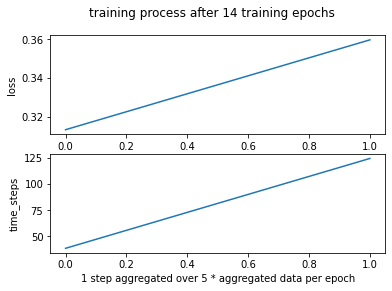

In [10]:
step = 0
for e in range(epochs):
    print("collecting experience..")
    # update normalization
    manager.kwargs["model_kwargs"]["normalize_mean"] = moving_mean
    manager.kwargs["model_kwargs"]["normalize_sd"] = moving_sd
    
    # run agents
    if e == 0:
        data = manager.get_data(total_steps=buffer_size)
    else:
        data = manager.get_data()

    manager.store_in_buffer(data)
    
    # sample data as tf datasets to optimize on from buffer
    sample_dict = manager.sample(sample_size)
    print(f"collected data for: {sample_dict.keys()}")
    # create and batch tf datasets
    data_list = list(dict_to_dict_of_datasets(sample_dict, batch_size=optim_batch_size).values())

    # get seperate network for delayed DQN
    update_QNetwork = QNetwork(**manager.kwargs["model_kwargs"])
    delay_Qnetwork = QNetwork(**manager.kwargs["model_kwargs"])
    # get current weights for update Q-Network
    weights = agent.get_weights()
    update_QNetwork.set_weights(weights)
    delay_Qnetwork.set_weights(weights)
    
    losses = []
    for i, (state, action, reward, next_state, not_done) in enumerate(zip(*data_list)):
        # update moving average
        if step < 2000:
            moving_mean += 1 / (step + 125) * (np.mean(state, axis=0) - moving_mean)
            moving_sd += 1 / (step + 125) * (np.std(state, axis=0) - moving_sd)
        
        # get Q-values for next state of delayed network
        q_values = delay_Qnetwork(next_state)['q_values']
        # gompute target
        q_target = reward + gamma * tf.reduce_max(q_values, axis=-1).numpy() * not_done.numpy()
        
        # backpropagate loss
        with tf.GradientTape() as tape:
            output = update_QNetwork(state, training=True)['q_values']
            q_vals_actions_taken = tf.gather(output, action.numpy().astype(np.int32), batch_dims=1)
            loss = tf.keras.losses.MSE(q_target, q_vals_actions_taken)
        
        gradients = tape.gradient(loss, update_QNetwork.trainable_variables)    
        optimizer.apply_gradients(zip(gradients, update_QNetwork.trainable_variables))
        losses.append(np.mean(loss))
        
        # update delayed network
        old = [dqn_delay_rho * weight for weight in delay_Qnetwork.get_weights()]
        new = [(1 - dqn_delay_rho) * weight for weight in update_QNetwork.get_weights()]
        delay_Qnetwork.set_weights([old_w + new_w for old_w, new_w in zip(old, new)])
        
        # exponential temperature decay
        manager.kwargs["temperature"] *= temperature_decay
        
        step += 1
    
    manager.set_agent(update_QNetwork.get_weights())
    agent = manager.get_agent()
    
    # print progress
    time_steps = manager.test(test_steps)
    manager.update_aggregator(loss=losses, time_steps=time_steps)
    print(
        f"epoch ::: {e}  loss ::: {np.round(np.mean(losses), 4)}   avg env steps ::: {np.mean(time_steps)}   current lr ::: {np.round(optimizer._decayed_lr('float32').numpy(), 4)}"
    )
    if np.mean(time_steps) >= 198:
            # you can save models
            manager.save_model(saving_path, e)
            break

In [11]:
# and load mmodels
manager.load_model(saving_path)
print("done")
print("testing optimized agent")
manager.test(test_steps, test_episodes=10, render=True)

loading model...
done
testing optimized agent


[499, 499, 499, 499, 499, 346, 499, 499, 499, 499]